In [17]:
import numpy as np
import pandas as pd
import pickle
import matplotlib.pyplot as plt
import collections

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import (
    train_test_split,
    cross_validate
)
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.multiclass import OneVsOneClassifier

%matplotlib inline

In [2]:
def mean_std_cross_val_scores(model, X_train, y_train, **kwargs):
    """
    Returns mean and std of cross validation
    Parameters
    ----------
    model :
        scikit-learn model
    X_train : numpy array or pandas DataFrame
        X in the training data
    y_train :
        y in the training data
    Returns
    ----------
        pandas Series with mean scores from cross_validation
    """
    scores = cross_validate(model, X_train, y_train, **kwargs)
    mean_scores = pd.DataFrame(scores).mean()
    std_scores = pd.DataFrame(scores).std()
    out_col = []
    for i in range(len(mean_scores)):
        out_col.append(
            (f"%0.3f (+/- %0.3f)" % (mean_scores[i], std_scores[i]))
        )
    return pd.Series(data=out_col, index=mean_scores.index)

In [3]:
with open("data/processed/training_data.pickle", "rb") as f:
    training_data = pickle.load(f)

with open("data/processed/training_arm.pickle", "rb") as f:
    training_arm = pickle.load(f)
    
with open("data/processed/mean_trajectory.pickle", "rb") as f:
    mean_trajectory = pickle.load(f)

In [4]:
print(training_data.shape)
print(training_arm.shape)

(40000, 298)
(40000, 3000)


In [5]:
data = np.concatenate((training_data, training_arm), axis=1)
data.shape

(40000, 3298)

In [6]:
X_train, X_test, y_train_arm, y_test_arm = train_test_split(
    data[:, :297], data[:, 297:],
    test_size=0.3, random_state=2022
)

y_train = y_train_arm[:, 0]
y_test = y_test_arm[:, 0]

arm_train = y_train_arm[:, 1:]
arm_test = y_test_arm[:, 1:]

print(X_train.shape)
print(y_train.shape)
print(arm_train.shape)

(28000, 297)
(28000,)
(28000, 3000)


In [7]:
lr_pipe = make_pipeline(
    StandardScaler(),
    OneVsOneClassifier(LogisticRegression(max_iter=2000))
)

results_lr = mean_std_cross_val_scores(
    lr_pipe, X_train, y_train, return_train_score=True
)

pd.DataFrame(results_lr)

,0
fit_time,5.005 (+/- 0.470)
score_time,0.051 (+/- 0.007)
test_score,0.978 (+/- 0.001)
train_score,0.995 (+/- 0.000)


In [8]:
lr_pipe.fit(X_train, y_train)
print(lr_pipe.score(X_train, y_train))
print(lr_pipe.score(X_test, y_test))

0.9934642857142857
0.9805


In [9]:
out_file = "trained_models/lr.pickle"
with open(out_file, "wb") as f:
    pickle.dump(lr_pipe, f)

In [10]:
predictions = lr_pipe.predict(X_test)
predictions.shape

(12000,)

In [11]:
RMSE = 0
for idx, i in enumerate(predictions):
    predicted_trajectory = mean_trajectory[f"dir_{int(i)}"]
    actual_trajectory = arm_test[idx, :]
    RMSE = (RMSE +
            (1 / predictions.shape[0]) *
            np.sqrt(np.mean(
                (actual_trajectory - predicted_trajectory)**2)))

print(f"RMSE = {RMSE}")
print(f"Accuracy = {100 * sum(predictions == y_test) / y_test.shape[0]}")

RMSE = 53.08746124272516
Accuracy = 98.05


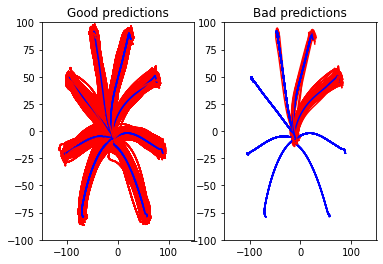

In [12]:
ax_good = plt.subplot(121)
ax_bad = plt.subplot(122)

incorrect_preds = []
correct_preds = []
for i in range(predictions.shape[0]):
    if not(int(predictions[i]) == y_test[i]):
        incorrect_preds.append(int(predictions[i]))
        predicted_trajectory = mean_trajectory[f"dir_{int(predictions[i])}"]
        actual_trajectory = arm_test[i, :]
        ax_bad.plot(actual_trajectory[:1000], actual_trajectory[1000:2000],
                color="r")
        ax_bad.plot(predicted_trajectory[:1000], predicted_trajectory[1000:2000],
                color="b")
    else:
        correct_preds.append(int(predictions[i]))
        predicted_trajectory = mean_trajectory[f"dir_{int(predictions[i])}"]
        actual_trajectory = arm_test[i, :]
        ax_good.plot(actual_trajectory[:1000], actual_trajectory[1000:2000],
                color="r")
        ax_good.plot(predicted_trajectory[:1000], predicted_trajectory[1000:2000],
                color="b")
ax_good.title.set_text("Good predictions")
ax_bad.title.set_text("Bad predictions")
ax_good.set_xlim([-150, 150])
ax_good.set_ylim([-100, 100])
ax_bad.set_xlim([-150, 150])
ax_bad.set_ylim([-100, 100])
plt.show()

In [20]:
corrects = collections.Counter(correct_preds)
wrongs = collections.Counter(incorrect_preds)

Counter({6: 1520, 5: 1513, 1: 1484, 3: 1478, 7: 1471, 2: 1471, 8: 1424, 4: 1405})
Counter({4: 41, 3: 39, 8: 34, 1: 33, 5: 31, 2: 31, 6: 14, 7: 11})


In [37]:
corrects_df = pd.DataFrame.from_dict(corrects, orient="index").reset_index().sort_values(by="index")
wrongs_df = pd.DataFrame.from_dict(wrongs, orient="index").reset_index().sort_values(by="index")
ratios_df = pd.merge(corrects_df, wrongs_df, on="index")
ratios_df.columns = ["index", "corrects", "wrongs"]
ratios_df["prop_correct"] = ratios_df["corrects"] / (ratios_df["corrects"] + ratios_df["wrongs"])
ratios_df.sort_values(by="prop_correct", ascending=False)

,index,corrects,wrongs,prop_correct
6,7,1471,11,0.992578
5,6,1520,14,0.990874
4,5,1513,31,0.979922
1,2,1471,31,0.979361
0,1,1484,33,0.978247
7,8,1424,34,0.976680
2,3,1478,39,0.974291
3,4,1405,41,0.971646


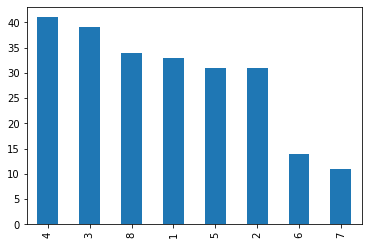

In [13]:
(pd.DataFrame({"incorrect_preds": incorrect_preds})["incorrect_preds"]
 .value_counts().plot(kind="bar"));

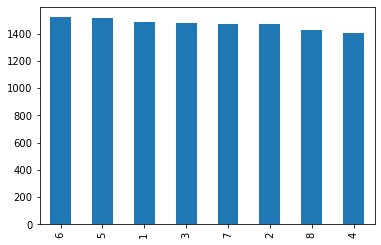

In [14]:
(pd.DataFrame({"correct_preds": correct_preds})["correct_preds"]
 .value_counts().plot(kind="bar"));